In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [2]:
# data preprocess
from tifffile import imread
from scipy import ndimage


def normalize(volume):
    """Normalize the volume"""
    volume[volume > 0] = 1
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize"""
    # Set the desired depth
    desired_depth = 32
    desired_width = 32
    desired_height = 32
    # Get current depth
    current_depth = img.shape[0]
    current_width = img.shape[-1]
    current_height = img.shape[1]
    # Compute depth factor
    depth_factor = desired_depth / current_depth
    width_factor = desired_width / current_width
    height_factor = desired_height / current_height
    resize_factor = np.amin([depth_factor, width_factor, height_factor])
    # Resize
    img = ndimage.zoom(img, resize_factor, order=0)
    new_depth = round(current_depth * resize_factor)
    new_width = round(current_width * resize_factor)
    new_height = round(current_height * resize_factor)
    a = round((40 - new_depth) / 2)
    b = 40 - new_depth - a
    c = round((40 - new_width) / 2)
    d = 40 - new_width - c
    e = round((40 - new_height) / 2)
    f = 40 - new_height -e
    img = np.pad(img, ((a,b),(e,f),(c,d)))
    img = np.asarray(img).astype('float32')
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = imread(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [3]:
# load data
rod_paths = [
    os.path.join(os.getcwd(), 'Data/ShapeIdentify/Training', x)
    for x in os.listdir('Data/ShapeIdentify/Training/Rod')
]
nonrod_paths = [
    os.path.join(os.getcwd(), 'Data/ShapeIdentify/Training/Non_rod', x)
    for x in os.listdir('Data/ShapeIdentify/Training/Non_rod')
]

print("Objects with rod-shaped: " + str(len(rod_paths)))
print("Objects with nonrod-shaped: " + str(len(nonrod_paths)))

Objects with rod-shaped: 411
Objects with nonrod-shaped: 322


In [4]:
# Build train and validation datasets

# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
rod_objects = np.array([process_scan(path) for path in rod_paths])
nonrod_objects = np.array([process_scan(path) for path in nonrod_paths])

# For the rod objects assign 1, for the nonrod ones assign 0.
rod_labels = np.array([1 for _ in range(len(rod_objects))])
nonrod_labels = np.array([0 for _ in range(len(nonrod_objects))])

# Create data
x_data = np.concatenate((rod_objects, nonrod_objects), axis=0)
y_data = np.concatenate((rod_labels, nonrod_labels), axis=0)

# Expand data
x_data = np.repeat(x_data, 6, axis=0)
y_data = np.repeat(y_data, 6, axis=0)

#Shuffle data
rng = np.random.RandomState(2021)
rng.shuffle(x_data)

rng = np.random.RandomState(2021)
rng.shuffle(y_data)

# Split data in the ratio 80-20 for training and validation.
num_train = int(0.8*len(x_data))
x_train = x_data[:num_train,:,:,:]
y_train = y_data[:num_train]

x_val = x_data[num_train:,:,:,:]
y_val = y_data[num_train:]
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 3518 and 880.


In [5]:
x_data.shape

(4398, 40, 40, 40)

In [6]:
# Data augmentation
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10,-5, 5, 10, 20]
        rot_axis = [(0,1), (0,2), (1,2)]
        # pick angles and axis at random
        angle_choice = random.choice(angles)
        axis_choice = random.choice(rot_axis)
        # rotate volume
        volume = ndimage.rotate(volume, angle=angle_choice, axes=axis_choice, reshape=False, order=0)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def flip(volume):
    """Flip the volume"""

    def np_flip(volume):
        flip_axis = [0, 1, 2]
        axis_choice = random.choice(flip_axis)
        # rotate volume
        volume = np.flip(volume, axis=axis_choice)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(np_flip, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = flip(volume)
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [7]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 5
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the object is: (40, 40, 40, 1)


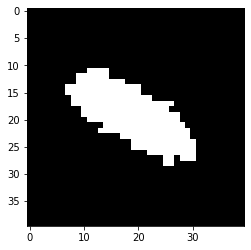

In [8]:
#visualize augmentation result 
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the object is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 16]), cmap="gray")

In [9]:
from tensorflow import keras
def get_model(width=40, height=40, depth=40):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=40, height=40, depth=40)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 40, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 38, 38, 38, 32)    896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 19, 19, 19, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 19, 19, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 17, 17, 17, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 8, 8, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 8, 64)       256   

In [10]:
# Compile model.
#initial_learning_rate = 0.0002
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "models/3d_image_classification1008.h5", save_best_only=True
)


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1, mode='auto', min_delta=0.01)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, reduce_lr],
)

Epoch 1/100
704/704 - 46s - loss: 0.5867 - acc: 0.6825 - val_loss: 0.6903 - val_acc: 0.5977
Epoch 2/100
704/704 - 12s - loss: 0.4784 - acc: 0.7723 - val_loss: 0.3612 - val_acc: 0.8534
Epoch 3/100
704/704 - 12s - loss: 0.4253 - acc: 0.8101 - val_loss: 0.3267 - val_acc: 0.8670
Epoch 4/100
704/704 - 12s - loss: 0.4006 - acc: 0.8300 - val_loss: 0.3279 - val_acc: 0.8659
Epoch 5/100
704/704 - 12s - loss: 0.3662 - acc: 0.8448 - val_loss: 0.4531 - val_acc: 0.8034
Epoch 6/100
704/704 - 11s - loss: 0.3596 - acc: 0.8394 - val_loss: 0.5087 - val_acc: 0.7591
Epoch 7/100
704/704 - 12s - loss: 0.3370 - acc: 0.8633 - val_loss: 0.4123 - val_acc: 0.8193
Epoch 8/100
704/704 - 11s - loss: 0.3075 - acc: 0.8729 - val_loss: 0.2766 - val_acc: 0.8795
Epoch 9/100
704/704 - 12s - loss: 0.3012 - acc: 0.8729 - val_loss: 0.3133 - val_acc: 0.8761
Epoch 10/100
704/704 - 11s - loss: 0.2902 - acc: 0.8809 - val_loss: 0.3224 - val_acc: 0.8773
Epoch 11/100
704/704 - 12s - loss: 0.2773 - acc: 0.8874 - val_loss: 0.2718 - va

model.add(layers.Flatten)
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary

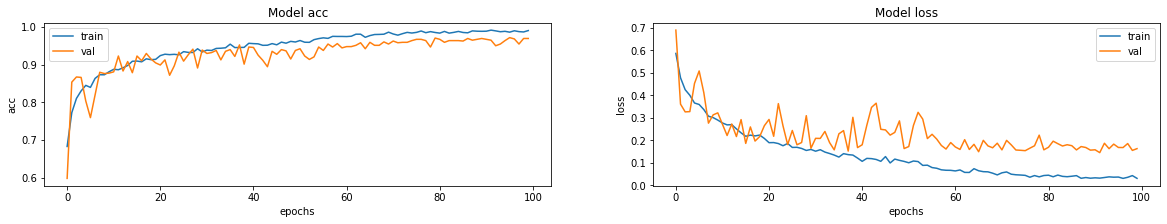

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])